### Overview

The dataset we will be using is a collection of amazon reviews for instant video products found at http://jmcauley.ucsd.edu/data/amazon/. Our set includes the reviews’ product, reviewer, text review, rating, helpfulness/unhelpfulness, and other metadata. The specific dataset we are using is a “5-core” dataset meaning that it includes only products and reviewers that have more than 5 reviews on amazon. This means that each product in this dataset has at least 5 reviews and that each reviewer in this dataset has posted at least 5 reviews for this category. The set includes over 37,000 reviews. 

### Purpose

This data was originally collected by Amazon as consumers browsed, bought, and reviewed products. This data is necessary for amazon to be able to display the reviews on each product. The specific dataset we are using is UCSD’s collection that has been structured by two researchers (Julian McAuley, Alex Yang) to understand why and what reviews are helpful to consumers when it comes to purchasing an object. They outline their findings with this data in the following paper: http://cseweb.ucsd.edu/~jmcauley/pdfs/www16b.pdf

### Prediction Task

Reviews have become increasingly crucial in consumer purchase decisions. As discussed in a BrightLocal study, 88% of consumers incorporate reviews into their purchase decisions. This finding for most consumers is obvious. A less obvious finding is that although customers are relying more on review data, they are reading less of them. It was found that by reading up to six reviews 73% of consumers formed an opinion as opposed to 64% in 2014. Moreover, it was found that by reading just one to three reviews 40% of consumers formed an opinion as opposed to 29% in 2014. 

Due to the importance of consumer reviews, online marketplaces such as Amazon are interested in learning which products are the most well-reviewed, and businesses are interested in analyzing consumer sentiment about their products. Thus, our goal is predicting the star rating (on a scale of 1 to 5) that a particular user gave a product based on the text of their review.

The application of this system is that, given a system that can match an Amazon review to a star value, we could apply this system to other forms of text reviews that do not include a star review, such as tweets or (short) blog posts. This would allow companies to get a fuller picture of their star rating, rather than just Amazon product reviews.

### Evaluation Metric

Our data is heavily class imbalanced. We have 5 categories of rating, and a score of 5 (the highest) happens 56% of the time, whereas a score of 1 (the lowest) happens only 4.6% of the time. We feel that it is important for online marketplaces and businesses making products to get a full understanding of negative reviews as well as positive reviews; metrics that do not account for class imbalance will make product reviews look much more positive than they actually are. As a consequence, we decide to use weighted F1 score as our evaluation metric. Weighted F1 score accounts for class imbalance in the categories, suiting our business case better than other metrics. Further, both precision and recall are important to our task. 

Precision is important because mislabeled reviews can give an incorrect picture of an individual reviewer's sentiment; perhaps a business will want to examine more closely all reviews with a 1 star score, for example, and send an email to each of these customers that attempts to resolve their issues. If our system incorrectly labels a review as 1 star when it is really more than 1 star, the business will waste time emailing this customer when they don't need to be emailed.

Recall is important because it represents completeness; how well did we represent the sentiment of users as a whole? If a company is interested in using our results to compute an overall star score, for example, the recall score is very important because it details if that score is representative of what users actually think or not.

### Train/Test Split

Because we do not have an especially large dataset, we will use stratified 10-fold cross validation to split our training and testing data. This fits with our proposed use case because the business using our services would want to train on an existing dataset (such as our Amazon review dataset) and apply the model to a different, but related, dataset (such as comments on the company's webpage or tweets at the company). There is not a time series aspect in our data to worry about either.

We will stratify the folds in our cross validation. Our reasoning behind this decision is that stratification mirrors the real use case for our system. The reason why there is a large class imbalance is likely motivated by the psychology of why people post reviews; it is unlikely that the bias towards positive reviews seen in our dataset is unique to our dataset. Rather, we would expect that an analysis of other datasets would reveal the same positive bias. Therefore, this class imbalance is something we want to preserve; lack of stratification would skew this class imbalance.

### Sources
BrightLocal, Business2community, Bazaarvoice, webrepublic, reprevive, Econsultancy,business2community,Reevoo and Social Media Today:

https://www.vendasta.com/blog/50-stats-you-need-to-know-about-online-reviews

Forbes: 

https://www.forbes.com/sites/jaysondemers/2015/12/28/how-important-are-customer-reviews-for-online-marketing/#276bfb421928

UCSD:

http://jmcauley.ucsd.edu/data/amazon/

http://cseweb.ucsd.edu/~jmcauley/pdfs/www16b.pdf




## 2. Data Processing
In this section we will prepare the dataset.

In [17]:
#Get rid of memory cached by jupyter notebook
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
#Imports
import sys
import numpy as np
import pandas as pd
import scipy

print(sys.version)
print(np.__version__)


#load dataset
dataframe = pd.read_json('review_Amazon_Instant_Video_5.json',lines=True)
dataframe.info()

3.5.2 (default, Mar 30 2017, 20:11:21) 
[GCC 5.4.0]
1.14.2
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.8+ MB


In [2]:
#extract information for number of reviews by each reviewer
reviewer_ids = list(dataframe['reviewerID'])
authorToNumReviews = {user_id:reviewer_ids.count(user_id) for user_id in set(reviewer_ids)}
dataframe['reviewLength'] = [len(text) for text in dataframe['reviewText']]
dataframe['reviewerNumberReviews'] = [authorToNumReviews[author] for author in dataframe['reviewerID']]

#extract additional columns for analysis
helpful_count = []
unhelpful_count = []
helpful_ratio = []
for (h,total) in dataframe['helpful']:
    helpful_count.append(h)
    unhelpful_count.append(total-h)
    if total == 0:
        helpful_ratio.append(None)
    else:
        helpful_ratio.append(h/(total))
dataframe['numberUnhelpful'] = unhelpful_count
dataframe['numberHelpful'] = helpful_count
dataframe['helpfulRatio'] = helpful_ratio

In [3]:
print('Number of reviews:',len(dataframe.overall))
print('Number of 5 star reviews:',sum(dataframe.overall==5))
print('Number of 1 star reviews:',sum(dataframe.overall==1))

Number of reviews: 37126
Number of 5 star reviews: 20890
Number of 1 star reviews: 1718


From this analysis we verify that the review score is heavily class imbalanced.

### 2.1. Data types
The features of this dataset are as follows :
+ asin - ID of the product - Nominal
+ helpful - A tuple containing the number of people that thought the review was helpful or unhelpful - Both ordinal, stored as integers
+ overall - The overall rating that a product received. Ordinal, stored as integer
+ reviewText - The full text of the review - Bag of words
+ reviewTime - The timestamp of the review - Interval
+ reviewerID - The ID of the reviewer - Nominal
+ reviewerName - The name of the reviewer - Nominal
+ summary - A summary of the review  - Bag of words
+ unixReviewTime - The UNIX timestamp of the review - Interval
   

### 2.2. Data quality

We analyze the general dataframe at hand to get a better understanding of the overall data quality.

In [99]:
#Number of null_data in any of the columns. 
null_data = dataframe[dataframe.isnull().any(axis=1)]
len(null_data)

24095

In [100]:
#Print the number of duplicate entries in the dataset
len(dataframe[dataframe.duplicated(['asin','reviewerID'],keep=False)])

0

In [101]:
#More information about the dataset
dataframe.describe()

,overall,unixReviewTime,reviewLength,reviewerNumberReviews,numberUnhelpful,numberHelpful,helpfulRatio
count,37126.00000,3.712600e+04,37126.000000,37126.000000,37126.000000,37126.000000,13133.000000
mean,4.20953,1.376795e+09,515.292033,10.667026,0.725475,1.293541,0.574588
std,1.11855,3.054958e+07,835.145610,13.346323,3.532468,8.301778,0.391384
min,1.00000,9.754560e+08,4.000000,5.000000,0.000000,0.000000,0.000000
25%,4.00000,1.367798e+09,145.000000,5.000000,0.000000,0.000000,0.200000
50%,5.00000,1.384992e+09,232.000000,7.000000,0.000000,0.000000,0.666667
75%,5.00000,1.394150e+09,484.000000,10.000000,0.000000,1.000000,1.000000
max,5.00000,1.406074e+09,18152.000000,123.000000,214.000000,484.000000,1.000000


### 2.3. Tokenization and preprocessing

In [4]:
import numpy as np
import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from sklearn.model_selection import StratifiedKFold
import nltk
import string
import re
words = set(nltk.corpus.words.words())

#use the nltk corpus of English words to filter special characters and non-English words
def english_filter(passed_string):
    passed_string = re.sub(r'[^\w\s]','',passed_string)
    passed_string = re.sub(' +',' ',passed_string)
    passed_string = ' '.join(y for y in passed_string.splitlines())
    passed_string = passed_string.rstrip()
    passed_string = passed_string.rstrip('\n')
    passed_string = " ".join((w if w in words else "") for w in passed_string.split(' '))
    passed_string = text_to_word_sequence(passed_string, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True, split=' ')
    return passed_string

#divide attributes by ordinal and nominal, pasted from previous lab
unneeded_attributes = ['unixReviewTime', 'helpful', 'reviewTime']
ordinal_attributes = ['numberHelpful', 'numberUnhelpful', 'reviewLength', 'overall', 'reviewerNumberReviews']
nominal_attributes = ['asin', 'reviewerID', 'reviewerName']

for attr in unneeded_attributes:
    if attr in dataframe:
        del dataframe[attr]

#set correct attribute type to overall rating 
dataframe[ordinal_attributes] = dataframe[ordinal_attributes].astype(np.int64)
dataframe['reviewText'] = dataframe.apply(lambda row: english_filter(row['reviewText']), axis=1)

#adapted from notebook 13- RNN Basics
NUM_TOP_WORDS = None
max_review_length = 200

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(dataframe['reviewText'])

X = tokenizer.texts_to_sequences(dataframe['reviewText'])
X = sequence.pad_sequences(X, maxlen=max_review_length)
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))


y = dataframe['overall']

skf = StratifiedKFold(n_splits=10, shuffle=True)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train=[]
X_test=[]
y_train=[]
y_test = []

for train_index, test_index in skf.split(X, y):
    X_train.append(X[train_index])
    X_test.append(X[test_index])
    y_train.append(y[train_index])
    y_test.append(y[test_index])


/users7/cse/spopov/CSE5324/CSE5324-Labs/ml/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 21110 unique tokens. Distilled to 21110 top words.


In [5]:
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (37126, 200)
Shape of label tensor: (37126,)


### 2.4. Creating the embedding layers

In [6]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(21111, 100)
CPU times: user 11.9 s, sys: 521 ms, total: 12.4 s
Wall time: 12.5 s


In [7]:
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=max_review_length,
                            trainable=False)

### 2.5.1 LSTM Model
We first tried using a LSTM model with an Adam optimizer and ReLu activation on the Dense layer. We did not use softmax or sigmoid activation, since we are dealing with a regression problem. For time purposes, we decided to only fit the model on the first 3 folds of our 10 fold SFold.

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(1, activation='relu'))
adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
rnn.compile(loss='mean_squared_error', 
              optimizer=adam, 
              metrics=['mse'])#,weighted_f1])
rnn.save_weights('lstm1_initial_weights.h5')

print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2111100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,191,601
Trainable params: 80,501
Non-trainable params: 2,111,100
_________________________________________________________________
None


In [9]:
history_rnn= []
for index in range(0,3):
    rnn.load_weights('lstm1_initial_weights.h5')
    history_rnn.append(rnn.fit(X_train[index], y_train[index], validation_data=(X_test[index], y_test[index]), epochs=5, batch_size=64, shuffle=True))

Train on 33412 samples, validate on 3714 samples
Epoch 1/5
33412/33412 [==============================] - 216s 6ms/step - loss: 1.2357 - mean_squared_error: 1.2357 - val_loss: 1.4267 - val_mean_squared_error: 1.4267
Epoch 2/5
33412/33412 [==============================] - 209s 6ms/step - loss: 1.0475 - mean_squared_error: 1.0475 - val_loss: 0.9467 - val_mean_squared_error: 0.9467
Epoch 3/5
33412/33412 [==============================] - 206s 6ms/step - loss: 0.9628 - mean_squared_error: 0.9628 - val_loss: 1.0020 - val_mean_squared_error: 1.0020
Epoch 4/5
33412/33412 [==============================] - 207s 6ms/step - loss: 1.1271 - mean_squared_error: 1.1271 - val_loss: 1.0147 - val_mean_squared_error: 1.0147
Epoch 5/5
33412/33412 [==============================] - 204s 6ms/step - loss: 1.0077 - mean_squared_error: 1.0077 - val_loss: 0.9690 - val_mean_squared_error: 0.9690
Train on 33412 samples, validate on 3714 samples
Epoch 1/5
33412/33412 [==============================] - 206s 6ms/s

The following plots show how our first model performed over each training iteration. In this case, we combined the results of each training iteration over the separate folds and plotted the results. This means iterations 0-2 would correspond to fold 1, 3-5 to fold 2, 6-8 to fold 3 and so on.

Visualization for fold  1 : 



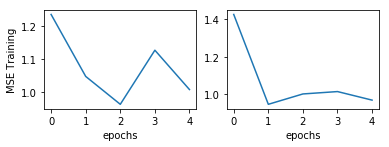

Visualization for fold  2 : 



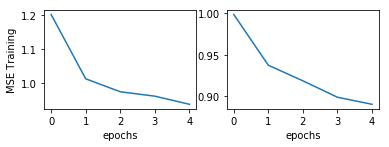

Visualization for fold  3 : 



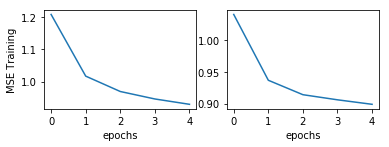

In [10]:
from matplotlib import pyplot as plt

%matplotlib inline
lstm1_stats = []

for x in range(0,3):
    print("Visualization for fold ", x+1,": \n")
    plt.title('Training')

    plt.subplot(2,2,1)
    plt.plot(history_rnn[x].history['mean_squared_error'])
    plt.ylabel('MSE Training')
    plt.xlabel('epochs')

    plt.subplot(2,2,2)
    plt.plot(history_rnn[x].history['val_mean_squared_error'])
    plt.xlabel('epochs')
    lstm1_stats.append(history_rnn[x].history['val_mean_squared_error'][-1])
    plt.show()

We then tuned the parameters of our LSTM model to use an linear activation function at a decreased learning rate. 

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import optimizers

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(1, activation='linear'))
adam = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rnn.compile(loss='mean_squared_error', 
              optimizer=adam, 
              metrics=['mse'])#,weighted_f1])

rnn.save_weights('lstm_linear_initial_weights.h5')

print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2111100   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 2,191,601
Trainable params: 80,501
Non-trainable params: 2,111,100
_________________________________________________________________
None


In [12]:
%%time
history_rnn3= []
for index in range(0,3):
    print("Fold " + str(index+1))
    rnn.load_weights('lstm_linear_initial_weights.h5')
    history_rnn3.append(rnn.fit(X_train[index], y_train[index], validation_data=(X_test[index], y_test[index]), epochs=5, batch_size=64, shuffle=True))

Fold 1
Train on 33412 samples, validate on 3714 samples
Epoch 1/5
33412/33412 [==============================] - 206s 6ms/step - loss: 1.2495 - mean_squared_error: 1.2495 - val_loss: 0.9499 - val_mean_squared_error: 0.9499
Epoch 2/5
33412/33412 [==============================] - 206s 6ms/step - loss: 0.9237 - mean_squared_error: 0.9237 - val_loss: 0.8531 - val_mean_squared_error: 0.8531
Epoch 3/5
33412/33412 [==============================] - 211s 6ms/step - loss: 0.8529 - mean_squared_error: 0.8529 - val_loss: 0.8327 - val_mean_squared_error: 0.8327
Epoch 4/5
33412/33412 [==============================] - 215s 6ms/step - loss: 0.8248 - mean_squared_error: 0.8248 - val_loss: 0.8083 - val_mean_squared_error: 0.8083
Epoch 5/5
33412/33412 [==============================] - 211s 6ms/step - loss: 0.8022 - mean_squared_error: 0.8022 - val_loss: 0.8461 - val_mean_squared_error: 0.8461
Fold 2
Train on 33412 samples, validate on 3714 samples
Epoch 1/5
33412/33412 [==============================

Similarly, we plot the MSE over each training iteration.

Visualization for fold  1 : 



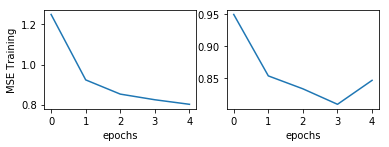

Visualization for fold  2 : 



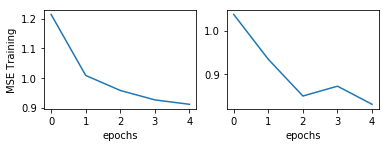

Visualization for fold  3 : 



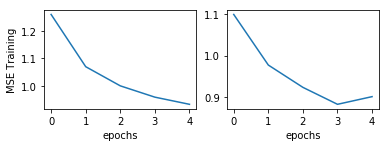

In [13]:
from matplotlib import pyplot as plt

%matplotlib inline
lstm2_stats = []

for x in range(0,3):
    print("Visualization for fold ", x+1,": \n")
    plt.title('Training')

    plt.subplot(2,2,1)
    plt.plot(history_rnn3[x].history['mean_squared_error'])
    plt.ylabel('MSE Training')
    plt.xlabel('epochs')

    plt.subplot(2,2,2)
    plt.plot(history_rnn3[x].history['val_mean_squared_error'])
    plt.xlabel('epochs')
    lstm2_stats.append(history_rnn3[x].history['val_mean_squared_error'][-1])
    plt.show()

### 2.5.2 GRU Model

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras import optimizers



rnn_1 = Sequential()
rnn_2 = Sequential()
rnn_3 = Sequential()

rnn_list = [rnn_1,rnn_2,rnn_3]

for r in rnn_list:
    r.add(embedding_layer)
    r.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
    r.add(Dense(1, activation='relu'))
    adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    r.compile(loss='mean_squared_error', 
                  optimizer=adam, 
                  metrics=['mse'])#,weighted_f1])

for r in rnn_list:
    print ("RNN :")
    print(r.summary())

RNN :
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2111100   
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,171,501
Trainable params: 60,401
Non-trainable params: 2,111,100
_________________________________________________________________
None
RNN :
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          2111100   
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               60300     
____________________________________________

In [16]:
history_gru = []

for fold in range(0,3):
    print ("Fold ",fold + 1, ": \n")
    history_rnn_temp= rnn_list[fold].fit(X_train[fold], y_train[fold], validation_data=(X_test[fold], y_test[fold]), epochs=5, batch_size=64, shuffle=True)
    history_gru.append(history_rnn_temp)

Fold  1 : 

Train on 33412 samples, validate on 3714 samples
Epoch 1/5
33412/33412 [==============================] - 182s 5ms/step - loss: 0.8215 - mean_squared_error: 0.8215 - val_loss: 0.8121 - val_mean_squared_error: 0.8121
Epoch 2/5
33412/33412 [==============================] - 186s 6ms/step - loss: 0.8417 - mean_squared_error: 0.8417 - val_loss: 0.8994 - val_mean_squared_error: 0.8994
Epoch 3/5
33412/33412 [==============================] - 185s 6ms/step - loss: 0.8607 - mean_squared_error: 0.8607 - val_loss: 0.8750 - val_mean_squared_error: 0.8750
Epoch 4/5
33412/33412 [==============================] - 184s 6ms/step - loss: 0.9808 - mean_squared_error: 0.9808 - val_loss: 0.9644 - val_mean_squared_error: 0.9644
Epoch 5/5
33412/33412 [==============================] - 184s 5ms/step - loss: 0.9430 - mean_squared_error: 0.9430 - val_loss: 0.9794 - val_mean_squared_error: 0.9794
Fold  2 : 

Train on 33412 samples, validate on 3714 samples
Epoch 1/5
33412/33412 [====================

Visualization for fold  1 : 



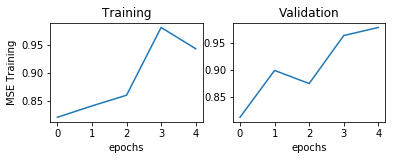

Visualization for fold  2 : 



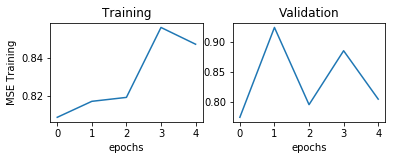

Visualization for fold  3 : 



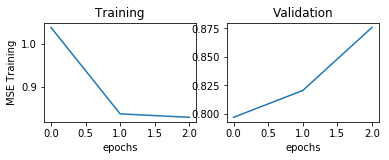

In [17]:
%matplotlib inline
gru_stats = []

for x in range(0,3):
    print("Visualization for fold ", x+1,": \n")
    

    plt.subplot(2,2,1)
    plt.plot(history_gru[x].history['mean_squared_error'])
    plt.ylabel('MSE Training')
    plt.xlabel('epochs')
    plt.title('Training')

    plt.subplot(2,2,2)
    plt.plot(history_gru[x].history['val_mean_squared_error'])
    plt.xlabel('epochs')
    gru_stats.append(history_gru[x].history['val_mean_squared_error'][-1])
    plt.title('Validation')
    plt.show()

In [21]:
print([x.history['loss'] for x in history_gru])
print([x.history['loss'] for x in history_rnn])
print([x.history['loss'] for x in history_rnn3])

[[0.8215404286312548, 0.8417078075359842, 0.8606960925316077, 0.9807863974163065, 0.9430470410384318], [0.8088857215863423, 0.8172284452273405, 0.8192875977192156, 0.8558082305841299, 0.8470522418616419], [1.0378053865610561, 0.8382950424933939, 0.8303463197990362, nan, nan]]
[[1.2356795508833285, 1.0475351260719679, 0.9628421299531477, 1.1270924775447444, 1.007660833581984], [1.2012050552709537, 1.0128537142232523, 0.9749618496250338, 0.9620450194347523, 0.9382509011844382], [1.207965491728684, 1.0168969749505257, 0.9692320613736637, 0.9460886241661871, 0.9295714434486484]]
[[1.249499915403391, 0.9237386484025096, 0.8529250128646246, 0.8248210803047135, 0.8021718598184194], [1.2139455861036583, 1.0082500977928903, 0.9575507840353272, 0.9257132913321917, 0.9108339046470051], [1.2604825331481733, 1.0699529729602466, 1.0000338203590473, 0.9588166076908936, 0.9327066052278244]]


### 2.6 Adding a recurrent chain to our best model
We add a second recurrent chain to our best model, which is shown to be the LSTM model with a 0.005 Adam learning rate and linear activation.

In [ ]:
rnn2 = Sequential()
rnn2.add(embedding_layer)
rnn2.add(GRU(100,dropout=0.2, recurrent_dropout=0.2,return_sequences=True ))
rnn2.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
rnn2.add(Dense(1, activation='relu'))
rnn2.compile(loss='mean_squared_error', 
              optimizer=adam, 
              metrics=['mse'])
rnn2.save_weights('rnn2_initial_weights.h5')
print(rnn2.summary())

In [ ]:
history_gru2 = []

for fold in range(0,3):
    print ("Fold ",fold + 1, ": \n")
    rnn2.load_weights('rnn2_initial_weights.h5')
    history_rnn_temp= rnn2.fit(X_train[fold], y_train[fold], validation_data=(X_test[fold], y_test[fold]), epochs=5, batch_size=64, shuffle=True)
    history_gru2.append(history_rnn_temp)

Text(0.5,1,'Validation')

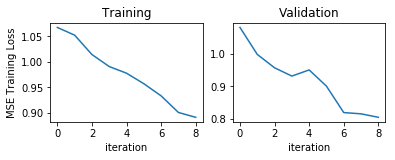

In [170]:
%matplotlib inline
plt.title('Training')
total_history = [x.history for x in history_rnn2]
losses = total_history[0]['loss'] + total_history[1]['loss'] + total_history[2]['loss']
val_mse = total_history[0]['val_mean_squared_error'] + total_history[1]['val_mean_squared_error'] + total_history[2]['val_mean_squared_error']

plt.subplot(2,2,3)
plt.plot(losses)
plt.ylabel('MSE Training Loss')
plt.xlabel('iteration')
plt.title('Training')

plt.subplot(2,2,4)
plt.plot(val_mse)
plt.xlabel('iteration')
plt.title('Validation')

In [178]:
import seaborn as sns
%matplotlib inline

mse1 = [x.history['val_mean_squared_error'][-1] for x in history_rnn]
mse2 = [x.history['val_mean_squared_error'][-1] for x in history_rnn2]
mse_gru = [x.history['val_mean_squared_error'][-1] for x in history_rnn_gru]
mse_best = [x.history['val_mean_squared_error'][-1] for x in history_rnn3]

print(np.mean(mse1), np.mean(mse_best), np.mean(mse_gru), np.mean(mse2))

0.911807983857918 0.7901928967145461 0.863089414119849 0.8877163039805581


Text(0,0.5,'Loss %')

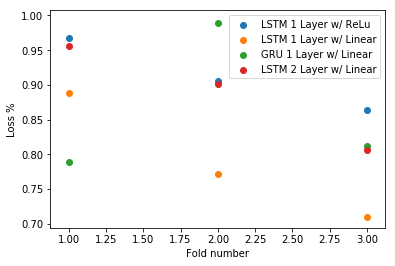

In [181]:
plt.scatter([x for x in range(1,4)], mse1, label='LSTM 1 Layer w/ ReLu')
plt.scatter([x for x in range(1,4)], mse_best, label='LSTM 1 Layer w/ Linear')
plt.scatter([x for x in range(1,4)], mse_gru,label='GRU 1 Layer w/ Linear')
plt.scatter([x for x in range(1,4)], mse2, label='LSTM 2 Layer w/ Linear')
plt.legend()
plt.xlabel('Fold number')
plt.ylabel('Loss %')

In [185]:
from scipy import stats
ttest = stats.ttest_ind(mse1,mse_best)
print(ttest)

Ttest_indResult(statistic=2.0201788704765686, pvalue=0.11347461695769587)


[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 2.677067
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.245045
[t-SNE] Error after 1000 iterations: 0.502354


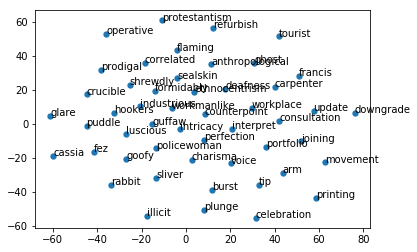

In [57]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
weights = []
weight_labels=[]
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        weights.append(embedding_vector)
        weight_labels.append(word)
        if len(weight_labels)==50:
            break
tsne = TSNE(n_components=2, verbose=1)
transformed_weights = tsne.fit_transform(weights)
fig, ax = plt.subplots()
ax.scatter(transformed_weights[:,0], transformed_weights[:,1],lw=0, s=40)
for i, txt in enumerate(weight_labels):
    ax.annotate(txt, (transformed_weights[:,0][i], transformed_weights[:,1][i]))
